In [3]:
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
import torchtuples as tt

from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

In [4]:
# base = '/data/processed_datasets/processed_datasets/mimic/phenotype/'
# phenotype = 'masld'
# model = 'motor'

# path = base + phenotype + '/' + model + '/features_with_label/'

base = '/user/zj2398/cache/motor_mimic_8k/embeddings/'
# phenotype_list = ['masld']
phenotype = 'stroke'
model = 'motor'
path = base + phenotype + '/' + model + '/features_with_label/'


In [70]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import meds_reader
import tqdm

meds_reader_path = "/user/zj2398/cache/mimic/meds_v0.6_reader"
database = meds_reader.SubjectDatabase(meds_reader_path)

dir_path = Path("/user/zj2398/ACES/output")
# for task in ["celiac", "masld", "stroke"]:

task = "celiac"
cohort_path = dir_path/task/f"{task}_cohort.parquet"
cohort = pd.read_parquet(cohort_path)
# cohort = cohort[(cohort["tte_label"]==False) &  cohort["time_to_event_days"].between(364, 366, inclusive='both')]
print(len(cohort))
# subject_id = cohort["subject_id"].tolist()
# prediction_time = cohort["prediction_time"].tolist()
# for event in database[subject_id[i]].events:
#     if event.time is not None and event.time >= prediction_time[i]:
#         print(event)

end_hos_discharge = []
no_hos_discharge = []
for index, row in tqdm(cohort.iterrows()):
    subject_id = row["subject_id"]
    prediction_time = row["prediction_time"]
    ed_out = False
    hospital_discharge = False
    for event in database[subject_id].events:
        # if current prediction time is ed_out
        if event.time is not None and event.time == prediction_time and event.code == "ED_OUT":
            ed_out = True
        ## if current prediction time is ed_out, does it have HOSPITAL_DISCHARGE"
        elif event.time is not None and event.time >= prediction_time and ed_out == True and event.code.startswith("HOSPITAL_DISCHARGE"):
            hospital_discharge = True
    if ed_out == True and hospital_discharge == False:
        no_hos_discharge.append(row)
    elif ed_out == True and hospital_discharge == True:
        end_hos_discharge.append(row)

print(end_hos_discharge)
print(no_hos_discharge)

## ed_out hospital_discharge// icu_discharge//

185185


TypeError: 'module' object is not callable

In [11]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path
import pandas as pd
import numpy as np
import meds_reader
import os

def _classify_chunk_by_path(chunk_df: pd.DataFrame, meds_reader_path: str):
    """Return (end_ids, no_ids) index lists for this chunk."""
    end_ids, no_ids = [], []
    with meds_reader.SubjectDatabase(meds_reader_path, num_threads=1) as db:
        # faster than iterrows; keep index to collect later
        for idx, subj_id, pred_time in chunk_df[["subject_id", "prediction_time"]].itertuples(name=None):
            try:
                subject = db[subj_id]
            except KeyError:
                continue  # subject missing; skip

            ed_out = False
            hospital_discharge = False

            # Walk events once, short-circuit when possible
            for ev in subject.events:
                t = ev.time
                if t is None:
                    continue
                # mark ED_OUT at the prediction time
                if (t == pred_time) and (ev.code == "ED_OUT"):
                    ed_out = True
                    # we keep scanning to see if a hospital discharge happens after this time
                    continue
                # if we've seen ED_OUT at pred_time, any later/equal discharge counts
                # or ev.code.startswith()
                if ed_out and (t >= pred_time) and (ev.code.startswith("HOSPITAL_DISCHARGE") or ev.code == "TRANSFER_TO//discharge//UNKNOWN"):
                    hospital_discharge = True
                    break  # found; no need to scan more

            if ed_out and not hospital_discharge:
                no_ids.append(idx)
            elif ed_out and hospital_discharge:
                end_ids.append(idx)
    return end_ids, no_ids


def split_and_classify_parallel(cohort: pd.DataFrame, meds_reader_path: str, max_workers: int | None = None):
    if max_workers is None:
        max_workers = max(1, os.cpu_count() or 1)

    # keep the original index so we can gather rows efficiently
    cohort = cohort.copy()
    cohort.reset_index(drop=False, inplace=True)  # column "index" will hold original index
    cohort.set_index("index", inplace=True)

    # make ~4 chunks per worker for decent load balancing
    n_chunks = max_workers * 4
    chunks = np.array_split(cohort, n_chunks)

    end_all, no_all = [], []
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(_classify_chunk_by_path, ch, meds_reader_path) for ch in chunks]
        for fut in as_completed(futures):
            end_ids, no_ids = fut.result()
            end_all.extend(end_ids)
            no_all.extend(no_ids)

    end_hos_discharge = cohort.loc[end_all]
    no_hos_discharge = cohort.loc[no_all]
    return end_hos_discharge, no_hos_discharge

meds_reader_path = "/user/zj2398/cache/mimic/meds_v0.6_reader"
database = meds_reader.SubjectDatabase(meds_reader_path)

dir_path = Path("/user/zj2398/ACES/output")
# for task in ["celiac", "masld", "stroke"]:

task = "celiac"
cohort_path = dir_path/task/f"{task}_cohort.parquet"
cohort = pd.read_parquet(cohort_path)

# ---- usage ----
end_df, no_df = split_and_classify_parallel(cohort, "/user/zj2398/cache/mimic/meds_v0.6_reader",100)
print(len(end_df), len(no_df))

# celiac that has ed_out as the prediction time: 80053 46 
#  masld 74925 62
#  stroke 52506 33


/user/zj2398/.conda/envs/tte/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


80089 10


In [4]:
import meds_reader
from pathlib import Path
meds_reader_path = "/user/zj2398/cache/mimic/meds_v0.6_reader"
database = meds_reader.SubjectDatabase(meds_reader_path)

dir_path = Path("/user/zj2398/ACES/output")
# for task in ["celiac", "masld", "stroke"]:

for event in database[10000032].events:
    print(event)

Event(time=None, code=GENDER//F, ...)
Event(time=2128-01-01 00:00:00, code=MEDS_BIRTH, ...)
Event(time=2180-03-23 11:51:00, code=LAB//50931//mg/dL, ...)
Event(time=2180-03-23 11:51:00, code=LAB//51071//UNK, ...)
Event(time=2180-03-23 11:51:00, code=LAB//51074//UNK, ...)
Event(time=2180-03-23 11:51:00, code=LAB//51075//UNK, ...)
Event(time=2180-03-23 11:51:00, code=LAB//51079//UNK, ...)
Event(time=2180-03-23 11:51:00, code=LAB//51087//UNK, ...)
Event(time=2180-03-23 11:51:00, code=LAB//51089//UNK, ...)
Event(time=2180-03-23 11:51:00, code=LAB//51090//UNK, ...)
Event(time=2180-03-23 11:51:00, code=LAB//51092//UNK, ...)
Event(time=2180-03-23 11:51:00, code=LAB//50853//ng/mL, ...)
Event(time=2180-03-23 11:51:00, code=LAB//50861//IU/L, ...)
Event(time=2180-03-23 11:51:00, code=LAB//50862//g/dL, ...)
Event(time=2180-03-23 11:51:00, code=LAB//50863//IU/L, ...)
Event(time=2180-03-23 11:51:00, code=LAB//50864//ng/mL, ...)
Event(time=2180-03-23 11:51:00, code=LAB//50868//mEq/L, ...)
Event(time=2

In [15]:
# print(no_df)

meds_reader_path = "/user/zj2398/cache/mimic/meds_v0.6_reader"
database = meds_reader.SubjectDatabase(meds_reader_path)

dir_path = Path("/user/zj2398/ACES/output")
# for task in ["celiac", "masld", "stroke"]:

task = "celiac"
cohort_path = dir_path/task/f"{task}_cohort.parquet"
cohort = pd.read_parquet(cohort_path)
# cohort = cohort[(cohort["tte_label"]==False) &  cohort["time_to_event_days"].between(364, 366, inclusive='both')]
print(len(cohort))

subject_id = no_df["subject_id"].tolist()
prediction_time = no_df["prediction_time"].tolist()

i=0
print(subject_id[i])
for event in database[subject_id[i]].events:
    if event.time is not None and event.time >= prediction_time[i]:
        print(event)

185185
19011416
Event(time=2182-01-04 14:56:00, code=ED_OUT, ...)
Event(time=2182-01-23 00:00:00, code=Blood Pressure, ...)
Event(time=2182-02-22 10:49:00, code=LAB//53173//UNK, ...)
Event(time=2182-02-22 10:49:00, code=LAB//53174//UNK, ...)
Event(time=2182-04-27 00:00:00, code=Blood Pressure, ...)


In [13]:
import pandas as pd
admit_path = ("/user/zj2398/cache/mimic/raw_3.1/admissions.csv")
transfer_path = ("/user/zj2398/cache/mimic/raw_3.1/transfers.csv")
# 19005931
admit = pd.read_csv(admit_path)
transfer = pd.read_csv(transfer_path)
print(len(admit))
print(len(transfer))
ed_only = transfer[transfer["hadm_id"].isna()]


546028
2413581


In [19]:
print(len(ed_only))
print(ed_only["hadm_id"].unique())

408977
[nan]


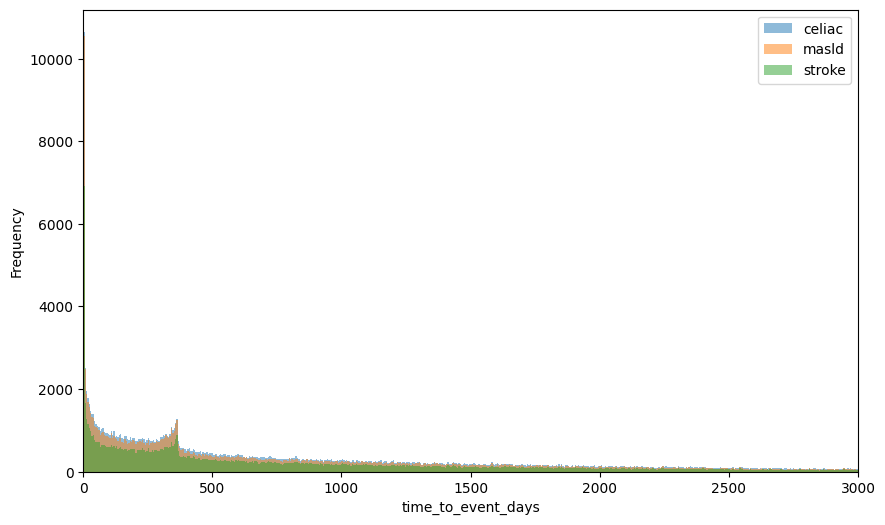

In [53]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

dir_path = Path("/user/zj2398/ACES/output")
plt.figure(figsize=(10, 6))
for task in ["celiac", "masld", "stroke"]:
    cohort_path = dir_path/task/f"{task}_cohort.parquet"
    cohort = pd.read_parquet(cohort_path)
    cohort = cohort[cohort["tte_label"] == False]
    cohort["time_to_event_days"].plot.hist(bins=1000, alpha=0.5, label=task)

plt.xlim(0, 3000)  # zoom in on first 100 days
plt.xlabel("time_to_event_days")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
# Use 10% for validation
from pathlib import Path
path = "/shared/share_mala/zj2398/mimic/phenotype/celiac"

train = pd.read_parquet(path + 'train.parquet')
val = train.sample(frac = 0.1, replace = False)
train = train.drop(val.index)
test = pd.read_parquet(path + 'test.parquet')

In [7]:
print(train)
# train['time_to_event_days'].max()/365

        subject_id     prediction_time  boolean_value  \
0         17947312 2154-08-28 13:30:00          False   
1         14066184 2140-10-07 01:15:00          False   
2         18237256 2117-03-01 11:00:00          False   
3         12330994 2177-06-27 14:04:00          False   
4         10538657 2149-03-12 21:55:00          False   
...            ...                 ...            ...   
281599    14244279 2151-02-06 07:17:41          False   
281600    19172342 2166-10-01 14:57:00          False   
281601    14686541 2122-08-16 16:08:00          False   
281602    15229574 2126-02-15 17:55:00          False   
281603    14313753 2204-08-24 09:11:00          False   

                                                 features  
0       [-1.1979039, 0.11037254, -0.70074356, -0.74835...  
1       [-0.94552845, -0.1191774, -0.58400804, 0.89763...  
2       [-1.0040412, -0.12654106, -0.682588, 0.3821438...  
3       [0.31768882, 1.2767233, -0.4727602, 0.18695708...  
4       [1.3246

In [8]:
train[~train.boolean_value].time_to_event_days.plot.hist(bins = 1000)

AttributeError: 'DataFrame' object has no attribute 'time_to_event_days'

In [ ]:
# Transform labels
num_durations = 100
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['time_to_event_days'].values, df['boolean_value'].values) 

# Extract features and labels
x_train = np.stack(train.features.values)
y_train = labtrans.fit_transform(*get_target(train))
train = (x_train, y_train)

x_val = np.stack(val.features.values)
y_val = labtrans.fit_transform(*get_target(val))
val = (x_val, y_val)

x_test = np.stack(test.features.values)
durations_test, events_test = get_target(test)

In [ ]:
# Define one layer NN for Deephit
in_features = x_train.shape[1]
out_features = labtrans.out_features

net = tt.practical.MLPVanilla(in_features, [], out_features)

In [ ]:
# Train Deephit
model = DeepHitSingle(net, tt.optim.Adam, duration_index=labtrans.cuts)
epochs, batch = 100, 2048
log = model.fit(x_train, y_train, batch, epochs, [tt.callbacks.EarlyStopping()], val_data=val)

In [ ]:
# Check loss on the train and validation set
_ = log.plot()

In [ ]:
# Predict on test set
surv = model.predict_surv_df(x_test)

In [ ]:
# Compute boostrapped performance
results = {'C-Index':[], 'Int-Brier':[]}
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
for boot in tqdm(range(100)):
    sample = np.random.choice(len(x_test), len(x_test))
    ev = EvalSurv(surv[sample], durations_test[sample], events_test[sample], censor_surv='km')
    results['C-Index'].append(ev.concordance_td('antolini'))
    results['Int-Brier'].append(ev.integrated_brier_score(time_grid))

In [ ]:
# Display
for metric in results:
    print('{}: {:.2f} ({:.2f})'.format(metric, np.mean(results[metric]), np.std(results[metric])))